In [1]:
#Using Knn Model

In [168]:
pip install fuzzywuzzy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import time
import math
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import fuzz
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline


C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
pip install python-Levenshtein

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for python-Levenshtein from https://files.pythonhosted.org/packages/27/89/c45dbdbd479453cfc8c4c1271c9f67fd607deaf84880e31c67b682980456/python_Levenshtein-0.23.0-py3-none-any.whl.metadata
  Obtaining dependency information for Levenshtein==0.23.0 from https://files.pythonhosted.org/packages/2f/04/a557197d0ba601f09fdd9ef9174b61d87706a291cd1e1578728eda3f44ab/Levenshtein-0.23.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for rapidfuzz<4.0.0,>=3.1.0 from https://files.pythonhosted.org/packages/fa/a9/0bcd4017323d40cec6fc1639eddae1f90b5e080be0c62eb34670b69aa009/rapidfuzz-3.6.1-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/101.1 kB ? eta -:--:--
   ---- ----------------------------------- 10.2/101.1 kB ? eta -:--:--
   ---- ----------------------------------- 10.2/101.1 kB ? eta -:--:--
   ---- --------------------------

In [29]:
dfmovies=pd.read_csv('movie.csv',
                    usecols=['movieId','title'],
                    dtype={'movieId':'int32','title':'str'})
dfratings = pd.read_csv(
    'rating.csv',
    usecols=['userId', 'movieId', 'rating'],
    dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})

In [30]:
dfmovies.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [31]:
dfratings.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


In [32]:
num_users = len(dfratings.userId.unique())
num_items = len(dfratings.movieId.unique())
print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_items))

There are 58 unique users and 2451 unique movies in this data set


In [33]:
df_ratings_cnt_tmp=pd.DataFrame(dfratings.groupby('rating').size(), columns=['count'])
df_ratings_cnt_tmp
df_movies_cnt_tmp=pd.DataFrame(dfratings.groupby('rating').size(), columns=['count'])

In [34]:
df_movies_cnt_tmp

,count
rating,
0.5,72
1.0,170
1.5,31
2.0,490
2.5,86
3.0,1647
3.5,368
4.0,2164
4.5,433


In [35]:
total_cnt = num_users * num_items    #total ratings
rating_zero_cnt=total_cnt-dfratings.shape[0] # zero ratings
df_ratings_cnt=df_ratings_cnt_tmp._append(pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
                                         verify_integrity=True,).sort_index()
df_movies_cnt = df_movies_cnt_tmp._append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True,
).sort_index()    # Appending a new row with count of zero ratings                                    

In [36]:
df_ratings_cnt

,count
0.0,135322
0.5,72
1.0,170
1.5,31
2.0,490
2.5,86
3.0,1647
3.5,368
4.0,2164
4.5,433


In [37]:
df_movies_cnt

,count
0.0,135322
0.5,72
1.0,170
1.5,31
2.0,490
2.5,86
3.0,1647
3.5,368
4.0,2164
4.5,433


In [38]:
df_ratings_cnt['log_count']=np.log(df_ratings_cnt['count']) #calculating natural log using numpy
df_movies_cnt['log_count'] = np.log(df_movies_cnt['count'])
df_movies_cnt

,count,log_count
0.0,135322,11.815412
0.5,72,4.276666
1.0,170,5.135798
1.5,31,3.433987
2.0,490,6.194405
2.5,86,4.454347
3.0,1647,7.406711
3.5,368,5.908083
4.0,2164,7.679714
4.5,433,6.070738


In [39]:
# Reset the index and rename the columns
x = df_ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'})
x


,rating score,count
0,0.0,135322
1,0.5,72
2,1.0,170
3,1.5,31
4,2.0,490
5,2.5,86
6,3.0,1647
7,3.5,368
8,4.0,2164
9,4.5,433


<Axes: title={'center': 'Count for Each Rating Score (in Log Scale)'}, xlabel='rating score', ylabel='number of ratings'>

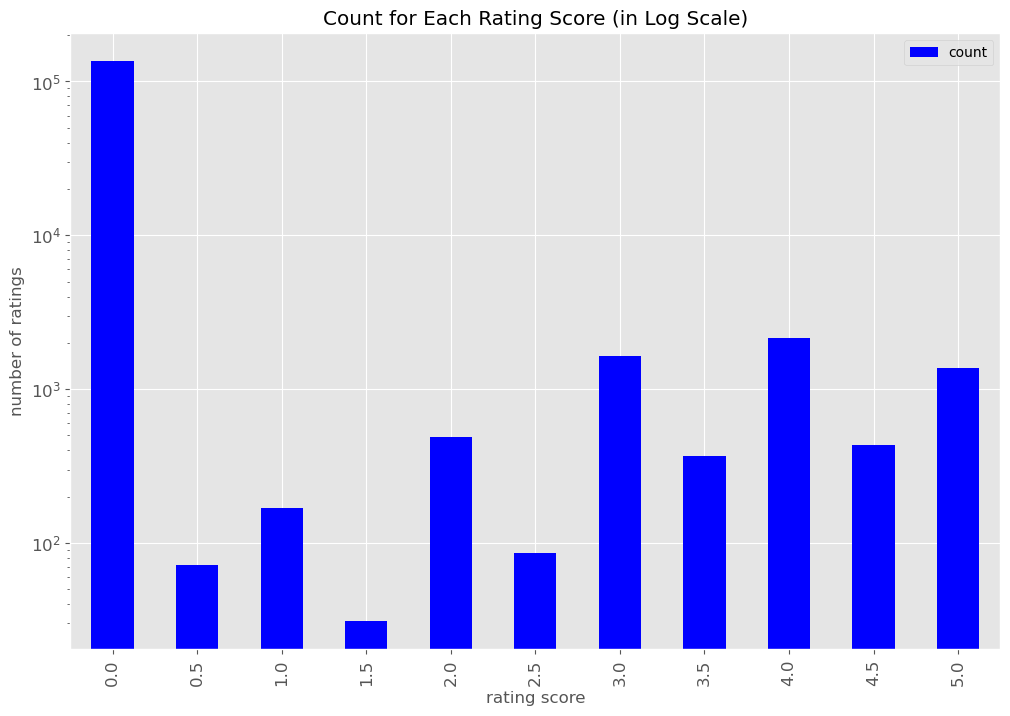

In [40]:
x.plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,
    xlabel='rating score',
    ylabel='number of ratings',
    color='blue'
)


Text(0, 0.5, 'number of ratings')

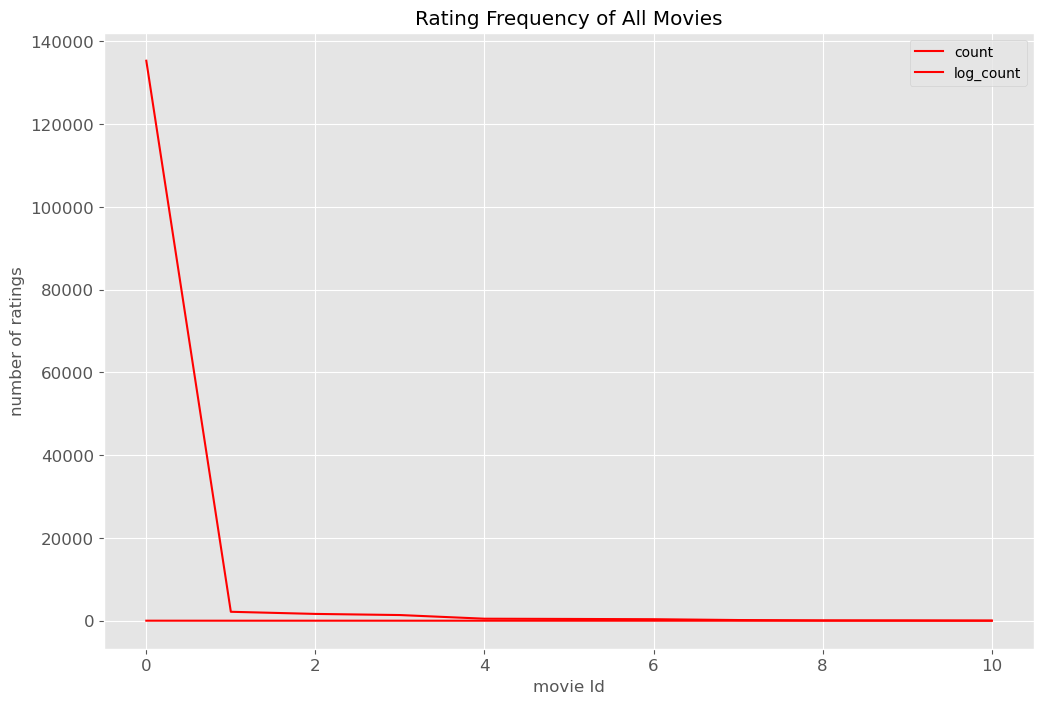

In [41]:
# plot rating frequency of all movies
f = df_movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies',
        fontsize=12,
        color='red'
    )
f.set_xlabel("movie Id")
f.set_ylabel("number of ratings")

In [42]:
# get rating frequency
df_movies_cnt = pd.DataFrame(dfratings.groupby('movieId').size(), columns=['count'])
df_movies_cnt.head()


,count
movieId,
1,20
2,6
3,7
4,1
5,5


In [43]:
df_movies_cnt['count'].quantile(np.arange(1, 0.6, -0.05))

1.00    33.0
0.95     9.0
0.90     6.0
0.85     5.0
0.80     4.0
0.75     3.0
0.70     3.0
0.65     2.0
Name: count, dtype: float64

In [46]:
popularity_thres = 20
popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_movies = dfratings[dfratings.movieId.isin(popular_movies)]
print('shape of original ratings data: ', dfratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies.shape)

shape of original ratings data:  (6836, 3)
shape of ratings data after dropping unpopular movies:  (431, 3)


In [48]:
# get number of ratings given by every user
df_users_cnt = pd.DataFrame(dfratings.groupby('userId').size(), columns=['count'])
df_users_cnt.head()


,count
userId,
1,175
2,61
3,187
4,28
5,66


In [49]:
df_users_cnt['count'].quantile(np.arange(1, 0.5, -0.05))

1.00    710.00
0.95    494.65
0.90    243.90
0.85    190.60
0.80    176.20
0.75    130.25
0.70    119.10
0.65     99.15
0.60     88.20
0.55     73.00
Name: count, dtype: float64

In [51]:
# filter data
ratings_thres = 50
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.userId.isin(active_users)]
print('shape of original ratings data: ', dfratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)

shape of original ratings data:  (6836, 3)
shape of ratings data after dropping both unpopular movies and inactive users:  (361, 3)


In [58]:
print(active_users)

[1, 2, 3, 5, 7, 8, 11, 13, 14, 16, 18, 19, 21, 22, 23, 24, 25, 26, 27, 29, 31, 32, 33, 34, 35, 38, 40, 41, 42, 43, 46, 47, 48, 50, 51, 53, 54, 56, 58]


In [60]:
dfratings.shape

(6836, 3)

In [52]:
# pivot and create movie-user matrix
movie_user_mat = df_ratings_drop_users.pivot(index='movieId', columns='userId', values='rating').fillna(0)
# create mapper from movie title to index
movie_to_idx = {
    movie: i for i, movie in 
    enumerate(list(dfmovies.set_index('movieId').loc[movie_user_mat.index].title))
}
# transform matrix to scipy sparse matrix
movie_user_mat_sparse = csr_matrix(movie_user_mat.values)

In [53]:
# define model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
# fit
model_knn.fit(movie_user_mat_sparse)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [54]:
def fuzzy_matching(mapper, fav_movie, verbose=True):
    """
    return the closest match via fuzzy ratio. If no match found, return None
    
    Parameters
    ----------    
    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie
    
    verbose: bool, print log if True

    Return
    ------
    index of the closest match
    """
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]



def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
    # fit
    model_knn.fit(data)
    # get input movie index
    print('You have input movie:', fav_movie)
    idx = fuzzy_matching(mapper, fav_movie, verbose=True)
    # inference
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    # get list of raw idx of recommendations
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))


In [56]:
my_favorite = 'Shawshank Redemption'

make_recommendation(
    model_knn=model_knn,
    data=movie_user_mat_sparse,
    fav_movie=my_favorite,
    mapper=movie_to_idx,
    n_recommendations=10)

You have input movie: Shawshank Redemption
Found possible matches in our database: ['Shawshank Redemption, The (1994)']

Recommendation system start to make inference
......

Recommendations for Shawshank Redemption:
1: Fugitive, The (1993), with distance of 0.3682120442390442
2: Forrest Gump (1994), with distance of 0.3410866856575012
3: Fargo (1996), with distance of 0.3381617069244385
4: Schindler's List (1993), with distance of 0.3010604977607727
5: Terminator 2: Judgment Day (1991), with distance of 0.2893575429916382
6: Braveheart (1995), with distance of 0.2488824725151062
7: Seven (a.k.a. Se7en) (1995), with distance of 0.24676555395126343
8: Usual Suspects, The (1995), with distance of 0.1807563304901123
9: Silence of the Lambs, The (1991), with distance of 0.13178539276123047
10: Pulp Fiction (1994), with distance of 0.1247704029083252
